# Графовые нейронные сети

In [2]:
import tensorflow as tf
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

### Граф - как распространенный формат данных 

**Граф** — это абстрактная структура данных, состоящая из вершин (узлов) и связей (рёбер). В графовых нейронных сетях он служит основой для моделирования сложных систем, таких как социальные сети, биологические структуры и транспортные сети.

**Графовые нейронные сети (GNN)** представляют собой мощный инструмент, который находит широкое применение в различных областях науки и техники. Они эффективно решают задачи обработки графов, что делает их незаменимыми для анализа социальных сетей, прогнозирования заболеваний и обработки текстовых данных.

Графы обладают уникальными возможностями для анализа и обработки информации. Они способны решать задачи поиска кратчайших путей, обнаружения циклов и определения связности, что делает их подходящими для широкого спектра приложений. Графы могут применяться для анализа социальных взаимодействий, прогнозирования распространения болезней и обработки текстовой информации, открывая новые горизонты в исследовании сложных систем.

Математически граф $G=(V, E)$ - это пара, где $V=\{v_i\}_{i=\overline{1,N}}$ - множество вершин в графе, $E=\{e_{ij}=(v_i, v_j): v_i, v_j \in V\}$. Графы назваются **ненаправленным**, если $e_{ij} = e_{ji}$. Если $e_{ij} = w_{ij} \in R$, то граф называется **взвешенным**.

Граф можно записать в виде **матрицы смежностей** $A=[a_{ij}]_{i,j=\overline{1,N}}$, $a_{ij} = e_{ij}$ если $e_{ij} \in E$, иначе $0$. Для него можно записать диагональную **матрица степеней** $D=[d_{jj}]$, где $d_{jj} = \sum_{i=\overline{1, N}}a_{ij}$. **Лапласиан графа** определяется как $L = D-A$.

Ключевая идея графовых сетей заключается в том, что если для матрицы $X_0=[x^0_1, x^0_2, ..., x^0_n]^T\in R^{N\times m}$ посчитать величину $X_1 = AX_0 W$, где $W\in R^{m\times m_2}$, то $X_1=[x^1_1, x^1_2, ..., x^1_n]^T\in R^{N\times m_2}$ будет характеризовать соседей узла.

### Классификация задач

##### По числу графов на входе: 
1. Один граф (граф постоянно меняется, но между итерациями изменения не значительны).
2. Много графов (значительно отличаются, как минимум один от остальных)

##### По уравню абстракции (на примере задачи классификации):
1. Graph-level (классификация графа)
2. Node-level (классификация узлов)
3. Edges-level (классификация ребер)

Здесь можно выделить задачу кластеризации на графе (Subgraph-level).


### Пример 1. Работа с большим графом - секции карате

Это хорошо известная и часто используемая сеть каратэ-клуба Закари. Данные были собраны Уэйном Закари в 1977 году среди членов университетского каратэ-клуба. Каждый узел представляет собой члена клуба, а каждое ребро — связь между двумя членами клуба. Сеть неориентированная. Часто обсуждаемая задача, связанная с этим набором данных, — найти две группы людей, на которые разделился каратэ-клуб после ссоры между двумя тренерами.

https://www.journals.uchicago.edu/doi/abs/10.1086/jar.33.4.3629752

In [3]:
import pandas as pd

club = pd.read_csv("karate-club.csv", names=["id_1", "id_2"])
classes = pd.read_csv("karate-classes.csv", names=["id", "class"])
classes["id"] += 1

In [4]:
club

,id_1,id_2
0,1,2
1,1,3
2,2,3
3,1,4
4,2,4
...,...,...
73,29,34
74,30,34
75,31,34
76,32,34


In [5]:
y = classes.sort_values("id")["class"].to_numpy()
classes

,id,class
0,7,0
1,5,0
2,11,0
3,6,0
4,17,0
5,12,1
6,13,1
7,1,1
8,18,1
9,22,1


Предположим, что в сети нам известно только про одного участника из каждого клуба. 

In [6]:
mask = [0, 4, 8, 24]
mask_test = [i for i in range(34) if not i in mask]

In [7]:
G = nx.Graph()
for _, row in club.iterrows():
    G.add_edge(row["id_1"], row["id_2"])

Отрисуем известное состояние

In [8]:
def plot_graph(G, y, pass_data, num=False):
    if num:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), node_color=y)
        return
    color = ["red", "blue", "green", "yellow", "gray"]
    colors = [color[-1] if i in pass_data else color[yi] for i, yi in enumerate(y) ]
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,node_color=colors)
    

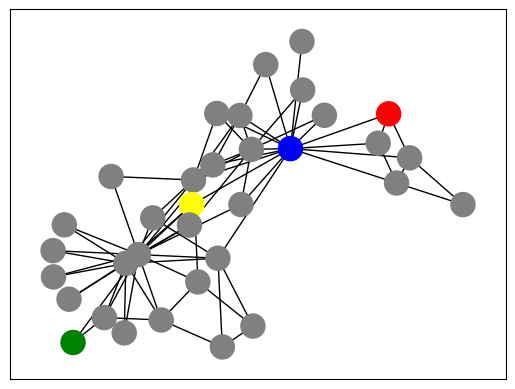

In [9]:
plot_graph(G, y, mask_test)

Для решениния задачи построим следующую графовую сеть:
- Содержит 2 слоя: графовый сверточный (с ReLu) и линейный (с Softmax)
- Функция потерь CategoricalCrossentropy 

In [10]:
class GNN(tf.Module):
    def __init__(self, l1, l2, l3):
        self.W1 = tf.Variable(tf.random.normal([l1, l2], stddev=0.1))
        self.W2 = tf.Variable(tf.random.normal([l2, l3], stddev=0.1))

    def __call__(self, A, X):
        X1 = tf.nn.relu(
            tf.matmul(tf.matmul(A, X), self.W1)
        )
        return tf.nn.softmax(tf.matmul(X1, self.W2))

main_loss = tf.losses.CategoricalCrossentropy()
@tf.function
def loss(x_pred, x_true, mask):
    pred_mask = tf.gather(x_pred, mask) 
    true_mask = tf.gather(x_true, mask) 
    return main_loss(pred_mask, true_mask)

Получение необходимых величин из таблиц

In [15]:
def get_A(club, classes):
    y = classes.sort_values("id")["id"].to_list()
    mtrx = np.zeros((len(y), len(y)), dtype=np.float32)
    for row in club.iterrows(): 
        id_1, id_2 = row[1]
        i = y.index(id_1)
        j = y.index(id_2)
        mtrx[i, j] = 1.0
        mtrx[j, i] = 1.0
    return tf.constant(mtrx)

def get_input(y): 
    return tf.constant(np.eye(len(y), dtype=np.float32))

def get_true_x(y):
    return tf.constant([[1 if yi == i else 0 for i in range(4)] for yi in y])

In [16]:
gnn = GNN(34, 20, 4)

Параметры обучения: 
- Эпох 20
- оптимизатор Adam (шаг 0.2)

In [17]:
A = get_A(club, classes)
X_true = get_true_x(y)
opt = tf.optimizers.Adam(learning_rate=0.2)

for i in range(20):
    X = get_input(y)
        
    with tf.GradientTape() as tape:
        X_pred = gnn(A, X)        
        X_loss = loss(X_pred, X_true, mask)
    grad = tape.gradient(X_loss, gnn.variables)    
    opt.apply_gradients(zip(grad, gnn.variables))
    print(f"EPOCH {i+1}:")
    print(f"loss: {X_loss.numpy():.4f}")

EPOCH 1:
loss: 12.2460
EPOCH 2:
loss: 8.7563
EPOCH 3:
loss: 5.2978
EPOCH 4:
loss: 1.7689
EPOCH 5:
loss: 0.2136
EPOCH 6:
loss: 0.0121
EPOCH 7:
loss: 0.0006
EPOCH 8:
loss: 0.0000
EPOCH 9:
loss: 0.0000
EPOCH 10:
loss: 0.0000
EPOCH 11:
loss: 0.0000
EPOCH 12:
loss: 0.0000
EPOCH 13:
loss: 0.0000
EPOCH 14:
loss: 0.0000
EPOCH 15:
loss: 0.0000
EPOCH 16:
loss: 0.0000
EPOCH 17:
loss: 0.0000
EPOCH 18:
loss: 0.0000
EPOCH 19:
loss: 0.0000
EPOCH 20:
loss: 0.0000


In [18]:
y = classes.sort_values("id")["class"].to_numpy()
A = get_A(club, classes)
X = get_input(y)
X_true = get_true_x(y)
X_pred = tf.argmax(gnn(A, X), axis=1)
print("Test")
print("\t\tpred \t| true")

for t in mask_test:
    a = classes[classes['id'] == t].iloc[0]['class']
    b = X_pred[t]
    print(f"Node {t}: \t{b} \t| {a} \t {'ok' if a == b else '*'}"  )

acc = tf.metrics.Accuracy()
# precision = tf.metrics.Precision()
# recall = tf.metrics.Recall()
print(30*"*")
print(f"Accuracy: {acc(X_pred, y)}")
# print(f"Precision: {precision(X_pred, y)}")
# print(f"Recall: {recall(X_pred, y)}")

Test
		pred 	| true
Node 1: 	1 	| 1 	 ok
Node 2: 	1 	| 1 	 ok
Node 3: 	1 	| 2 	 *
Node 5: 	0 	| 0 	 ok
Node 6: 	3 	| 0 	 *
Node 7: 	3 	| 0 	 *
Node 9: 	3 	| 3 	 ok
Node 10: 	3 	| 2 	 *
Node 11: 	0 	| 0 	 ok
Node 12: 	0 	| 1 	 *
Node 13: 	3 	| 1 	 *
Node 14: 	3 	| 1 	 *
Node 15: 	3 	| 3 	 ok
Node 16: 	0 	| 3 	 *
Node 17: 	0 	| 0 	 ok
Node 18: 	3 	| 1 	 *
Node 19: 	3 	| 3 	 ok
Node 20: 	3 	| 1 	 *
Node 21: 	0 	| 3 	 *
Node 22: 	3 	| 1 	 *
Node 23: 	3 	| 3 	 ok
Node 25: 	2 	| 2 	 ok
Node 26: 	3 	| 2 	 *
Node 27: 	3 	| 3 	 ok
Node 28: 	3 	| 2 	 *
Node 29: 	3 	| 2 	 *
Node 30: 	3 	| 3 	 ok
Node 31: 	3 	| 3 	 ok
Node 32: 	3 	| 2 	 *
Node 33: 	3 	| 3 	 ok
******************************
Accuracy: 0.5882353186607361


Точность не высокая, но изначально набор данных составляет 11.76%

Text(0.5, 1.0, 'Истинна')

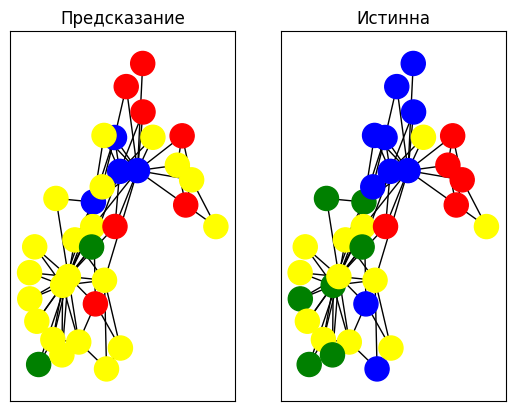

In [19]:
plt.subplot(121)
plot_graph(G, X_pred, [])
plt.title("Предсказание")
plt.subplot(122)
plot_graph(G, y, [])
plt.title("Истинна")

### Пример 2. Работа с набором графов - классификация молекул

Хорошо расписанный пример 
https://keras.io/examples/graph/mpnn-molecular-graphs/

Для предобработки необходима библиотека rdkit

In [20]:
# !pip install rdkit

In [21]:
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage
import warnings
warnings.filterwarnings("ignore")
RDLogger.DisableLog("rdApp.*")

np.random.seed(42)
tf.random.set_seed(42)

Набор данных понятен будет только для специалистов в этой области, ниже приведен код, который переводит молекулы к виду графов. Метки для классификации хранятся в колонке p_np.

In [22]:
df = pd.read_csv("BBBP.csv", usecols=[1, 2, 3])
df.iloc[96:104]

,name,p_np,smiles
96,cefoxitin,1,CO[C@]1(NC(=O)Cc2sccc2)[C@H]3SCC(=C(N3C1=O)C(O...
97,Org34167,1,NC(CC=C)c1ccccc1c2noc3c2cccc3
98,9-OH Risperidone,1,OC1C(N2CCC1)=NC(C)=C(CCN3CCC(CC3)c4c5ccc(F)cc5...
99,acetaminophen,1,CC(=O)Nc1ccc(O)cc1
100,acetylsalicylate,0,CC(=O)Oc1ccccc1C(O)=O
101,allopurinol,0,O=C1N=CN=C2NNC=C12
102,Alprostadil,0,CCCCC[C@H](O)/C=C/[C@H]1[C@H](O)CC(=O)[C@@H]1C...
103,aminophylline,0,CN1C(=O)N(C)c2nc[nH]c2C1=O.CN3C(=O)N(C)c4nc[nH...


In [23]:
class Featurizer:
    def __init__(self, allowable_sets):
        self.dim = 0
        self.features_mapping = {}
        for k, s in allowable_sets.items():
            s = sorted(list(s))
            self.features_mapping[k] = dict(zip(s, range(self.dim, len(s) + self.dim)))
            self.dim += len(s)

    def encode(self, inputs):
        output = np.zeros((self.dim,))
        for name_feature, feature_mapping in self.features_mapping.items():
            feature = getattr(self, name_feature)(inputs)
            if feature not in feature_mapping:
                continue
            output[feature_mapping[feature]] = 1.0
        return output


class AtomFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)

    def symbol(self, atom):
        return atom.GetSymbol()

    def n_valence(self, atom):
        return atom.GetTotalValence()

    def n_hydrogens(self, atom):
        return atom.GetTotalNumHs()

    def hybridization(self, atom):
        return atom.GetHybridization().name.lower()


class BondFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)
        self.dim += 1

    def encode(self, bond):
        output = np.zeros((self.dim,))
        if bond is None:
            output[-1] = 1.0
            return output
        output = super().encode(bond)
        return output

    def bond_type(self, bond):
        return bond.GetBondType().name.lower()

    def conjugated(self, bond):
        return bond.GetIsConjugated()


atom_featurizer = AtomFeaturizer(
    allowable_sets={
        "symbol": {"B", "Br", "C", "Ca", "Cl", "F", "H", "I", "N", "Na", "O", "P", "S"},
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3"},
    }
)

bond_featurizer = BondFeaturizer(
    allowable_sets={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},
    }
)

def molecule_from_smiles(smiles):
    # MolFromSmiles(m, sanitize=True) should be equivalent to
    # MolFromSmiles(m, sanitize=False) -> SanitizeMol(m) -> AssignStereochemistry(m, ...)
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)

    # If sanitization is unsuccessful, catch the error, and try again without
    # the sanitization step that caused the error
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule


def graph_from_molecule(molecule):
    # Initialize graph
    atom_features = []
    bond_features = []
    pair_indices = []

    for atom in molecule.GetAtoms():
        atom_features.append(atom_featurizer.encode(atom))

        # Add self-loops
        pair_indices.append([atom.GetIdx(), atom.GetIdx()])
        bond_features.append(bond_featurizer.encode(None))

        for neighbor in atom.GetNeighbors():
            bond = molecule.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx())
            pair_indices.append([atom.GetIdx(), neighbor.GetIdx()])
            bond_features.append(bond_featurizer.encode(bond))

    return np.array(atom_features), np.array(bond_features), np.array(pair_indices)


def graphs_from_smiles(smiles_list):
    # Initialize graphs
    atom_features_list = []
    bond_features_list = []
    pair_indices_list = []

    for smiles in smiles_list:
        molecule = molecule_from_smiles(smiles)
        atom_features, bond_features, pair_indices = graph_from_molecule(molecule)

        atom_features_list.append(atom_features)
        bond_features_list.append(bond_features)
        pair_indices_list.append(pair_indices)

    # Convert lists to ragged tensors for tf.data.Dataset later on
    return (
        tf.ragged.constant(atom_features_list, dtype=tf.float32),
        tf.ragged.constant(bond_features_list, dtype=tf.float32),
        tf.ragged.constant(pair_indices_list, dtype=tf.int64),
    )

def prepare_batch(x_batch, y_batch):
    """Merges (sub)graphs of batch into a single global (disconnected) graph
    """

    atom_features, bond_features, pair_indices = x_batch

    # Obtain number of atoms and bonds for each graph (molecule)
    num_atoms = atom_features.row_lengths()
    num_bonds = bond_features.row_lengths()

    # Obtain partition indices (molecule_indicator), which will be used to
    # gather (sub)graphs from global graph in model later on
    molecule_indices = tf.range(len(num_atoms))
    molecule_indicator = tf.repeat(molecule_indices, num_atoms)

    # Merge (sub)graphs into a global (disconnected) graph. Adding 'increment' to
    # 'pair_indices' (and merging ragged tensors) actualizes the global graph
    gather_indices = tf.repeat(molecule_indices[:-1], num_bonds[1:])
    increment = tf.cumsum(num_atoms[:-1])
    increment = tf.pad(tf.gather(increment, gather_indices), [(num_bonds[0], 0)])
    pair_indices = pair_indices.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    pair_indices = pair_indices + increment[:, tf.newaxis]
    atom_features = atom_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    bond_features = bond_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()

    return (atom_features, bond_features, pair_indices, molecule_indicator), y_batch


def MPNNDataset(X, y, batch_size=32, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, (y)))
    if shuffle:
        dataset = dataset.shuffle(1024)
    return dataset.batch(batch_size).map(prepare_batch, -1).prefetch(-1)


# Shuffle array of indices ranging from 0 to 2049
permuted_indices = np.random.permutation(np.arange(df.shape[0]))

# Train set: 80 % of data
train_index = permuted_indices[: int(df.shape[0] * 0.8)]
x_train = graphs_from_smiles(df.iloc[train_index].smiles)
y_train = df.iloc[train_index].p_np

# Valid set: 19 % of data
valid_index = permuted_indices[int(df.shape[0] * 0.8) : int(df.shape[0] * 0.99)]
x_valid = graphs_from_smiles(df.iloc[valid_index].smiles)
y_valid = df.iloc[valid_index].p_np

# Test set: 1 % of data
test_index = permuted_indices[int(df.shape[0] * 0.99) :]
x_test = graphs_from_smiles(df.iloc[test_index].smiles)
y_test = df.iloc[test_index].p_np

Так выглядят данные после предобработки

Name:	acetylsalicylate
SMILES:	CC(=O)Oc1ccccc1C(O)=O
BBBP:	0
Molecule:


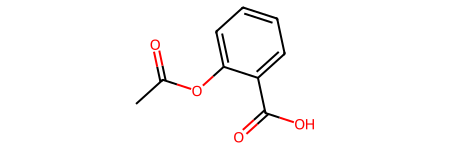

In [24]:
print(f"Name:\t{df.name[100]}\nSMILES:\t{df.smiles[100]}\nBBBP:\t{df.p_np[100]}")
molecule = molecule_from_smiles(df.iloc[100].smiles)
print("Molecule:")
molecule

Нам интересен вид графа

In [25]:
graph = graph_from_molecule(molecule)
print("Граф (включает петли, ненаправленный):")
print("\tНабор свойств атома (число атомов, свойства)\t|", graph[0].shape)
print("\tНабор свойств связей (число связей, свойства)\t|", graph[1].shape)
print("\tПары связанных атомов\t\t\t\t|", graph[2].shape)

Граф (включает петли, ненаправленный):
	Набор свойств атома (число атомов, свойства)	| (13, 29)
	Набор свойств связей (число связей, свойства)	| (39, 7)
	Пары связанных атомов				| (39, 2)


Далее создается модель, больший интерес представляет слой MessagePassing и связанный с ним EdgeNetwork, все остальное нужно для упрощения и ускорения обучения (правильного построения вычислительных графов, используемых для вычисления градиента). 

MessagePassing содержит слои обновления GRUCell, к графам напрямую он не имеет отношения.
Про математику слоя GRUCell можно почитать здесь https://pytorch.org/docs/stable/generated/torch.nn.GRUCell.html

In [26]:
class EdgeNetwork(tf.keras.layers.Layer):
    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1] # 29
        self.bond_dim = input_shape[1][-1] # 7
        self.kernel = self.add_weight(
            shape=(self.bond_dim, self.atom_dim * self.atom_dim),
            initializer="glorot_uniform",
            name="kernel",
        )
        self.bias = self.add_weight(
            shape=(self.atom_dim * self.atom_dim,), initializer="zeros", name="bias",
        )
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Линейный слой на выходе Nx(29*29)
        bond_features = tf.matmul(bond_features, self.kernel) + self.bias

        # Превращение обратно в тензор Nx29x29
        bond_features = tf.reshape(bond_features, (-1, self.atom_dim, self.atom_dim))

        # Получение атомарных свойств соседей (перемешивание для каждой пары индексов)
        # Nx29 -expand_dims-> Nx29x1
        atom_features_neighbors = tf.gather(atom_features, pair_indices[:, 1])
        atom_features_neighbors = tf.expand_dims(atom_features_neighbors, axis=-1)

        # [Nx29x29] x [Nx29x1] = Nx29x1 -squeeze-> Nx29
        transformed_features = tf.matmul(bond_features, atom_features_neighbors)
        transformed_features = tf.squeeze(transformed_features, axis=-1)
        aggregated_features = tf.math.unsorted_segment_sum(
            transformed_features,
            pair_indices[:, 0],
            num_segments=tf.shape(atom_features)[0],
        )
        return aggregated_features


class MessagePassing(tf.keras.layers.Layer):
    def __init__(self, units, steps=4, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.steps = steps

    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.message_step = EdgeNetwork()
        self.pad_length = max(0, self.units - self.atom_dim)
        self.update_step = tf.keras.layers.GRUCell(self.atom_dim + self.pad_length)
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Дополнительные единицы, если self.units > self.atom_dim
        atom_features_updated = tf.pad(atom_features, [(0, 0), (0, self.pad_length)])

        # Последовательный вызов отправки сообщений
        for i in range(self.steps):
            # Собранные агрегированные значения
            atom_features_aggregated = self.message_step(
                [atom_features_updated, bond_features, pair_indices]
            )

            # Обновление вектора
            atom_features_updated, _ = self.update_step(
                atom_features_aggregated, atom_features_updated
            )
        return atom_features_updated

class PartitionPadding(tf.keras.layers.Layer):
    def __init__(self, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size

    def call(self, inputs):

        atom_features, molecule_indicator = inputs

        # Obtain subgraphs
        atom_features_partitioned = tf.dynamic_partition(
            atom_features, molecule_indicator, self.batch_size
        )

        # Pad and stack subgraphs
        num_atoms = [tf.shape(f)[0] for f in atom_features_partitioned]
        max_num_atoms = tf.reduce_max(num_atoms)
        atom_features_stacked = tf.stack(
            [
                tf.pad(f, [(0, max_num_atoms - n), (0, 0)])
                for f, n in zip(atom_features_partitioned, num_atoms)
            ],
            axis=0,
        )

        # Remove empty subgraphs (usually for last batch in dataset)
        gather_indices = tf.where(tf.reduce_sum(atom_features_stacked, (1, 2)) != 0)
        gather_indices = tf.squeeze(gather_indices, axis=-1)
        return tf.gather(atom_features_stacked, gather_indices, axis=0)


class TransformerEncoderReadout(tf.keras.layers.Layer):
    def __init__(
        self, num_heads=8, embed_dim=64, dense_dim=512, batch_size=32, **kwargs
    ):
        super().__init__(**kwargs)

        self.partition_padding = PartitionPadding(batch_size)
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads, embed_dim)
        self.dense_proj = tf.keras.Sequential(
            [tf.keras.layers.Dense(dense_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.average_pooling = tf.keras.layers.GlobalAveragePooling1D()

    def call(self, inputs):
        x = self.partition_padding(inputs)
        padding_mask = tf.reduce_any(tf.not_equal(x, 0.0), axis=-1)
        padding_mask = padding_mask[:, tf.newaxis, tf.newaxis, :]
        attention_output = self.attention(x, x, attention_mask=padding_mask)
        proj_input = self.layernorm_1(x + attention_output)
        proj_output = self.layernorm_2(proj_input + self.dense_proj(proj_input))
        return self.average_pooling(proj_output)

def MPNNModel(
    atom_dim,
    bond_dim,
    batch_size=32,
    message_units=64,
    message_steps=4,
    num_attention_heads=8,
    dense_units=512,
):

    atom_features = tf.keras.layers.Input([atom_dim], dtype="float32", name="atom_features")
    bond_features = tf.keras.layers.Input([bond_dim], dtype="float32", name="bond_features")
    pair_indices = tf.keras.layers.Input([2], dtype="int32", name="pair_indices")
    molecule_indicator = tf.keras.layers.Input((),dtype="int32", name="molecule_indicator")
    
    x = MessagePassing(message_units, message_steps)(
        [atom_features, bond_features, pair_indices]
    ) # Ключевая операция, все остальное согласование и переход из-за разных размерностей.
   
    x = TransformerEncoderReadout(
        num_attention_heads, message_units, dense_units, batch_size
    )([x, molecule_indicator])
   
    x = tf.keras.layers.Dense(dense_units, activation="relu")(x)
    x = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(
        inputs=[atom_features, bond_features, pair_indices, molecule_indicator],
        outputs=[x],
    )
    return model

Здесь создается, настраивается модель и параметры обучения

In [27]:
mpnn = MPNNModel(
    atom_dim=x_train[0][0][0].shape[0], bond_dim=x_train[1][0][0].shape[0],
)
mpnn.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    metrics=[tf.keras.metrics.AUC(name="AUC")],
)

Получение наборов данных, обучение и отрисовка результатов

Epoch 1/40
52/52 - 17s - 321ms/step - AUC: 0.6896 - loss: 0.5441 - val_AUC: 0.8251 - val_loss: 0.5518
Epoch 2/40
52/52 - 10s - 183ms/step - AUC: 0.7872 - loss: 0.4699 - val_AUC: 0.8445 - val_loss: 0.5017
Epoch 3/40
52/52 - 11s - 206ms/step - AUC: 0.8057 - loss: 0.4556 - val_AUC: 0.8509 - val_loss: 0.5200
Epoch 4/40
52/52 - 11s - 209ms/step - AUC: 0.8140 - loss: 0.4466 - val_AUC: 0.8595 - val_loss: 0.5010
Epoch 5/40
52/52 - 9s - 176ms/step - AUC: 0.8226 - loss: 0.4399 - val_AUC: 0.8581 - val_loss: 0.5408
Epoch 6/40
52/52 - 9s - 176ms/step - AUC: 0.8290 - loss: 0.4348 - val_AUC: 0.8620 - val_loss: 0.5720
Epoch 7/40
52/52 - 9s - 176ms/step - AUC: 0.8349 - loss: 0.4290 - val_AUC: 0.8698 - val_loss: 0.5303
Epoch 8/40
52/52 - 9s - 176ms/step - AUC: 0.8480 - loss: 0.4127 - val_AUC: 0.8610 - val_loss: 0.5198
Epoch 9/40
52/52 - 9s - 176ms/step - AUC: 0.8511 - loss: 0.4084 - val_AUC: 0.8607 - val_loss: 0.5746
Epoch 10/40
52/52 - 9s - 176ms/step - AUC: 0.8532 - loss: 0.4026 - val_AUC: 0.8651 - va

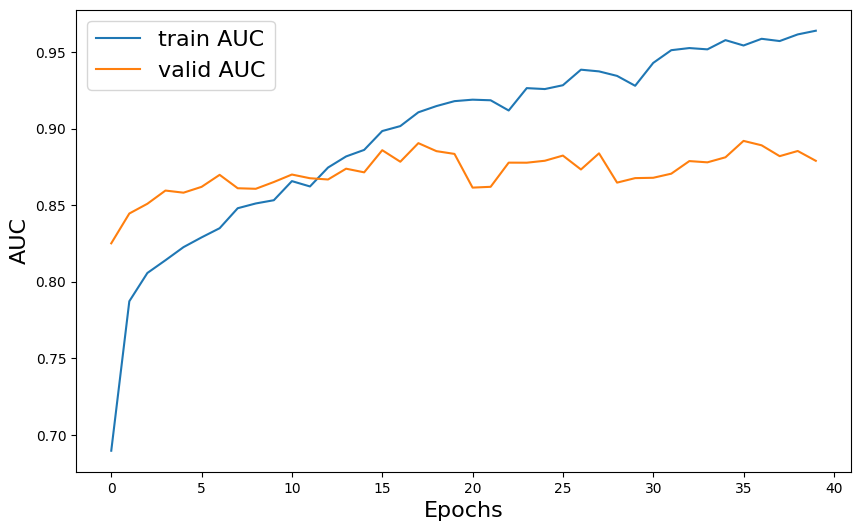

In [28]:
train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)
test_dataset = MPNNDataset(x_test, y_test)

history = mpnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=40,
    verbose=2,
    class_weight={0: 2.0, 1: 0.5},
)

plt.figure(figsize=(10, 6))
plt.plot(history.history["AUC"], label="train AUC")
plt.plot(history.history["val_AUC"], label="valid AUC")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("AUC", fontsize=16)
plt.legend(fontsize=16)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


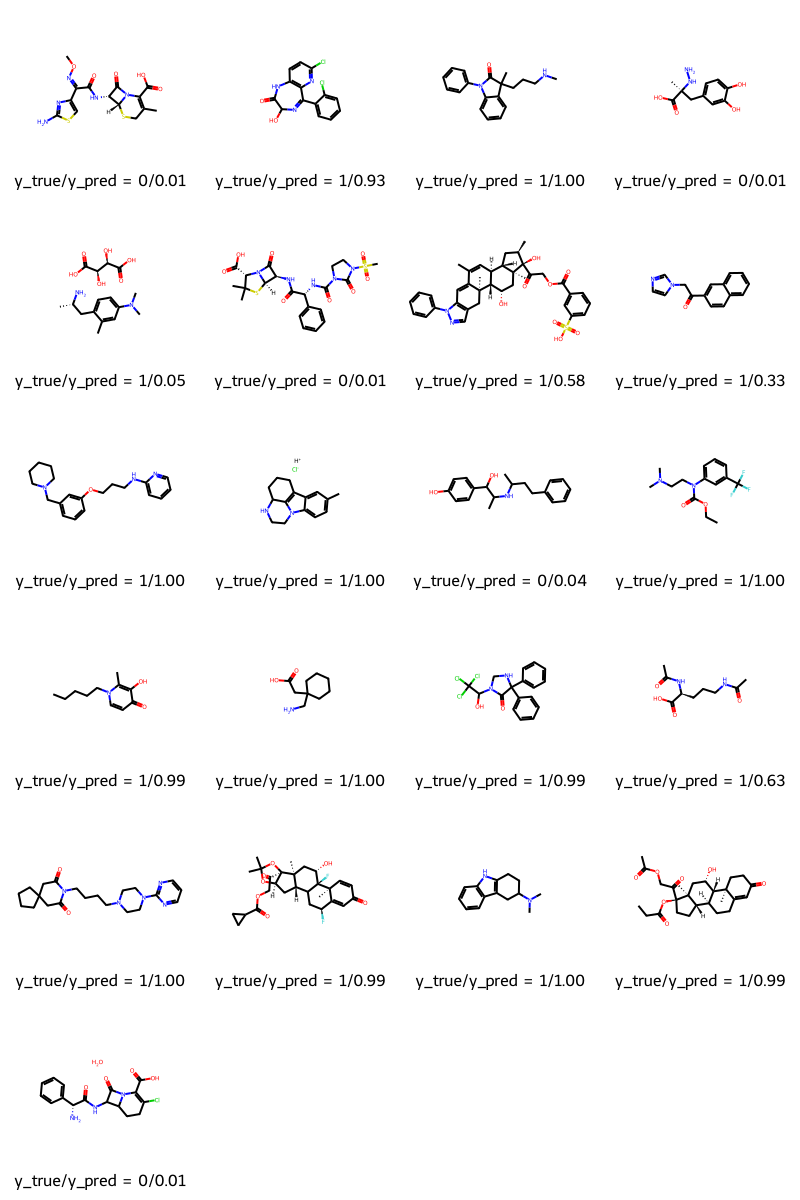

In [29]:
molecules = [molecule_from_smiles(df.smiles.values[index]) for index in test_index]
y_true = [df.p_np.values[index] for index in test_index]
y_pred = tf.squeeze(mpnn.predict(test_dataset), axis=1)

legends = [f"y_true/y_pred = {y_true[i]}/{y_pred[i]:.2f}" for i in range(len(y_true))]
MolsToGridImage(molecules, molsPerRow=4, legends=legends)

# Выводы

Графовые нейронные сети (GNN) сети являются обобщением сверточных сетей и вызывают большой интерес благодаря своей широкой применимости. Многие глобальные процессы, особенно социальные, могут быть описаны в виде графов, что делает их особенно привлекательными для изучения.

GNN не являются альтернативой сверточным слоям или многослойным перцептронам (MLP), а предлагают новые способы ввода данных, позволяя нейронным сетям работать с такой структурой, как граф.